# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](https://community.alteryx.com/t5/Data-Science/Beginner-s-Guide-to-Customer-Segmentation/ba-p/138442) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
import os

# Set the OMP_NUM_THREADS environment variable to 1
os.environ['OMP_NUM_THREADS'] = '1'

%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.decomposition 
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import random

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# to silence the warnings of openpyxl
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
# Merge transactions with offers
df_merged = pd.merge(df_transactions, df_offers, on='offer_id')

# Create a pivot table
pivot_table = pd.pivot_table(df_merged, values='n', index='customer_name', columns='offer_id', fill_value=0)

# Display the first few rows of the pivot table
pivot_table.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce three methods: the Elbow Sum-of-Squares method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

#### What values of  𝑆𝑆 do you believe represent better clusterings? Why?
Better clusterings are generally represented by lower SS values.  A lower SS value suggests that the data points are closer to their respective centroids, indicating tighter and more defined clusters.

#### Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 columns)

In [5]:
x_cols = pivot_table.to_numpy()

#### Write code that applies the KMeans clustering method from scikit-learn to this matrix.

In [6]:
from sklearn.cluster import KMeans

# Determining the range of K to try
k_range = range(2, 11)

# Applying K-Means clustering for different values of K
SS = []
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    model.fit(x_cols)
    SS.append(model.inertia_)

# Displaying the inertia for each K
SS_dict = dict(zip(k_range, SS))
SS_dict

{2: 252.1333333333333,
 3: 228.6930327868853,
 4: 220.2811274509804,
 5: 211.31333333333333,
 6: 199.35384615384612,
 7: 195.50163721413725,
 8: 181.06785542888494,
 9: 175.38663142413148,
 10: 166.9904650904651}

#### Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.

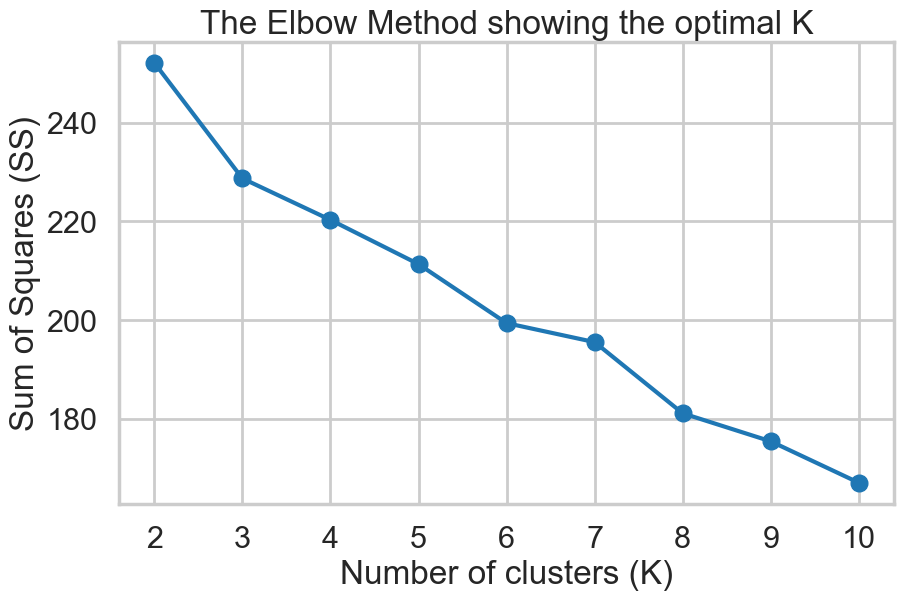

In [7]:
# Plotting SS for each K
plt.figure(figsize=(10, 6))
plt.plot(k_range, SS, marker='o')
plt.title('The Elbow Method showing the optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of Squares (SS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

#### Make a bar chart showing the number of points in each cluster for k-means under the best $K$.

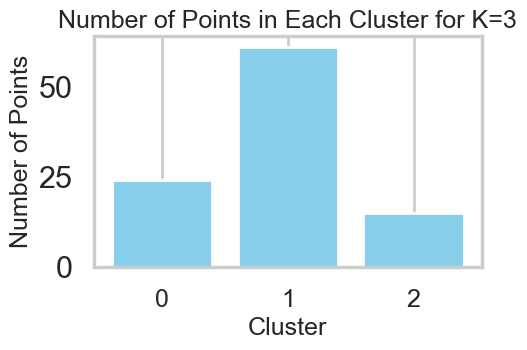

In [8]:
# subjective choice of the best K
best_k = 3

model_best_k = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
model_best_k.fit(x_cols)

# Counting the number of points in each cluster
clusters, counts = np.unique(model_best_k.labels_, return_counts=True)

# Plotting the bar chart
plt.figure(figsize=(5, 3))
plt.bar(clusters, counts, color='skyblue')
plt.title(f'Number of Points in Each Cluster for K={best_k}', fontsize=18)
plt.xlabel('Cluster', fontsize=18)
plt.ylabel('Number of Points', fontsize=18)
plt.xticks(clusters, fontsize=18)
plt.grid(axis='y')
plt.show()

#### What challenges did you experience using the Elbow method to pick $K$?

- **Subjective**: The Elbow Method relies on visual inspection to determine where the rate of decrease in the sum of squares (SS) begins to slow down significantly. This point can be ambiguous and may not always be clearly defined, leading to different interpretations.

- **Absence**: In this dataset, the elbow is not sharply defined. The plot shows a gradual curve rather than a clear bend.

- **Computationally expensive**

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

#### Exercise: Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.

For n_clusters = 2 The average silhouette_score is : 0.12976508334276524
For n_clusters = 3 The average silhouette_score is : 0.08710662290736483
For n_clusters = 4 The average silhouette_score is : 0.11975644774033015
For n_clusters = 5 The average silhouette_score is : 0.09789674887986952
For n_clusters = 6 The average silhouette_score is : 0.09901581266062229
For n_clusters = 7 The average silhouette_score is : 0.11343337310923207
For n_clusters = 8 The average silhouette_score is : 0.11784414239063822
For n_clusters = 9 The average silhouette_score is : 0.10203462068146302
For n_clusters = 10 The average silhouette_score is : 0.10681447486762781


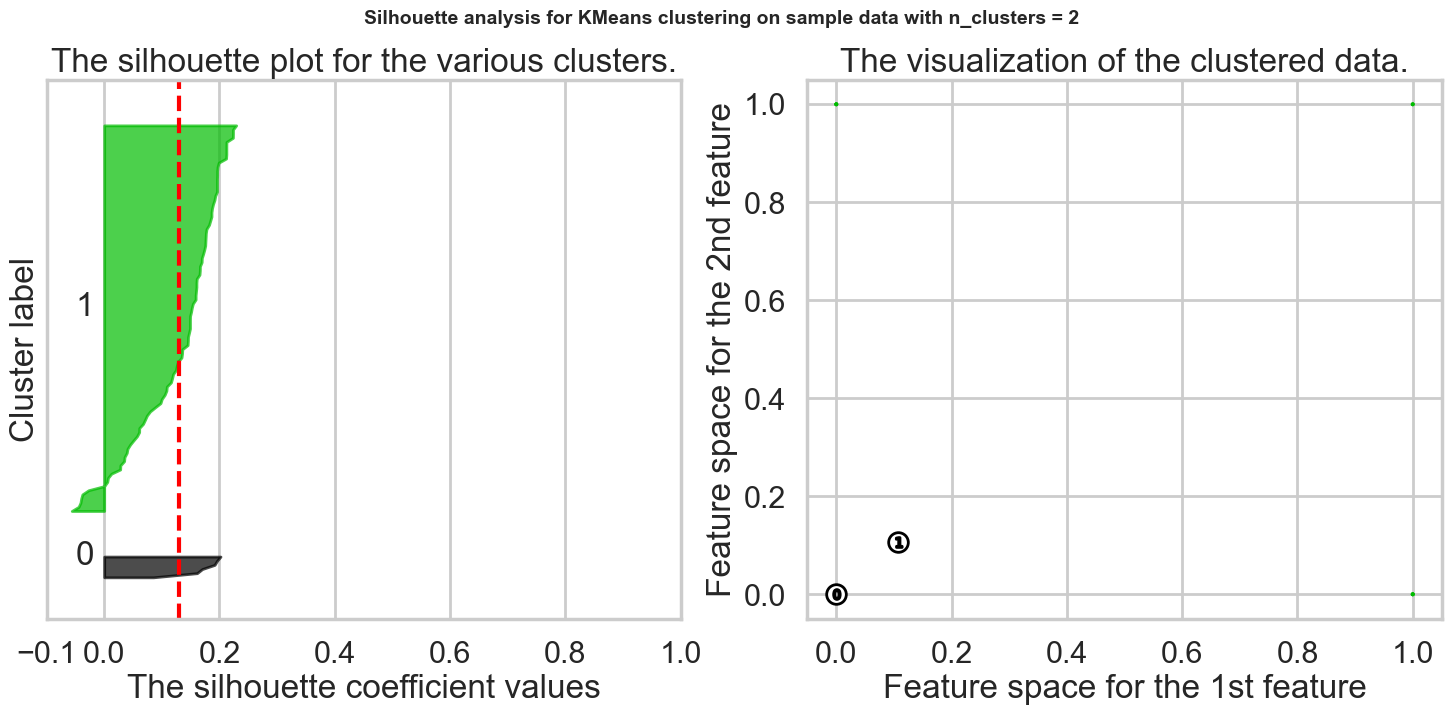

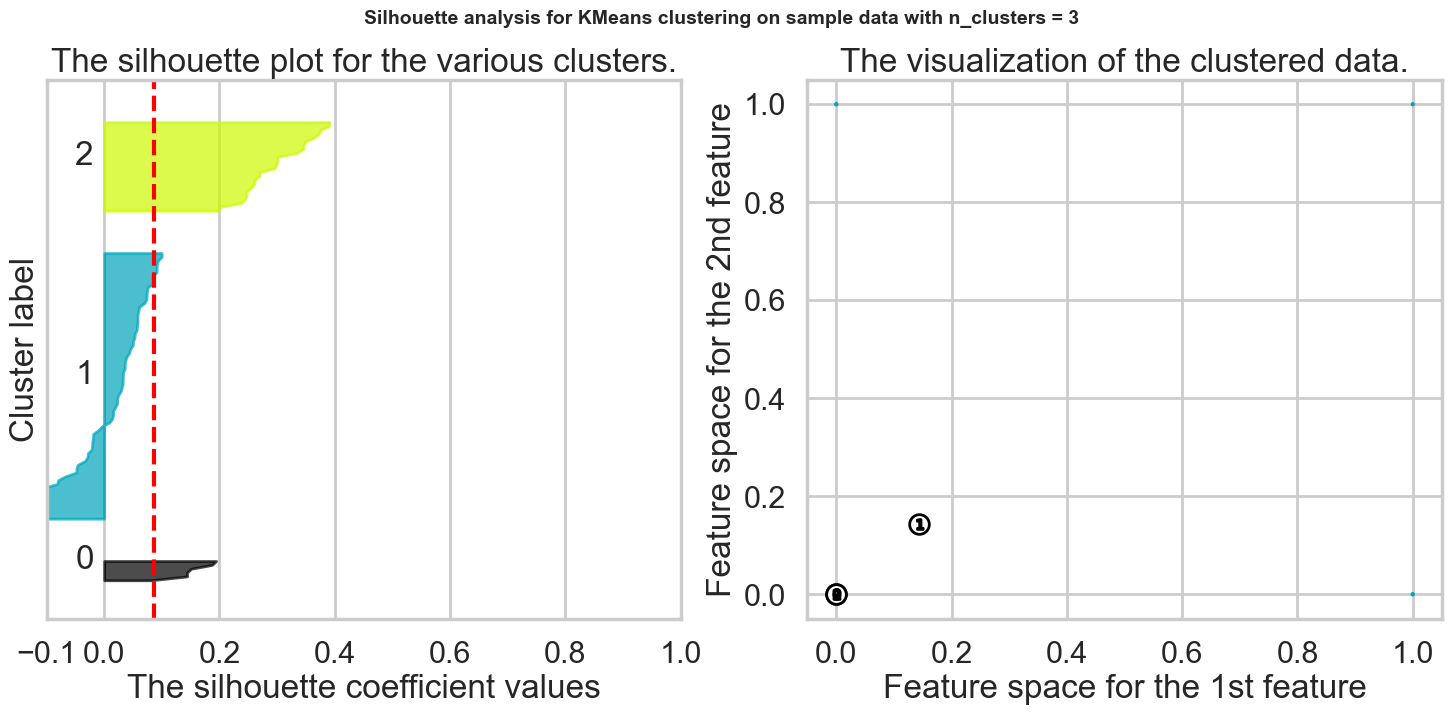

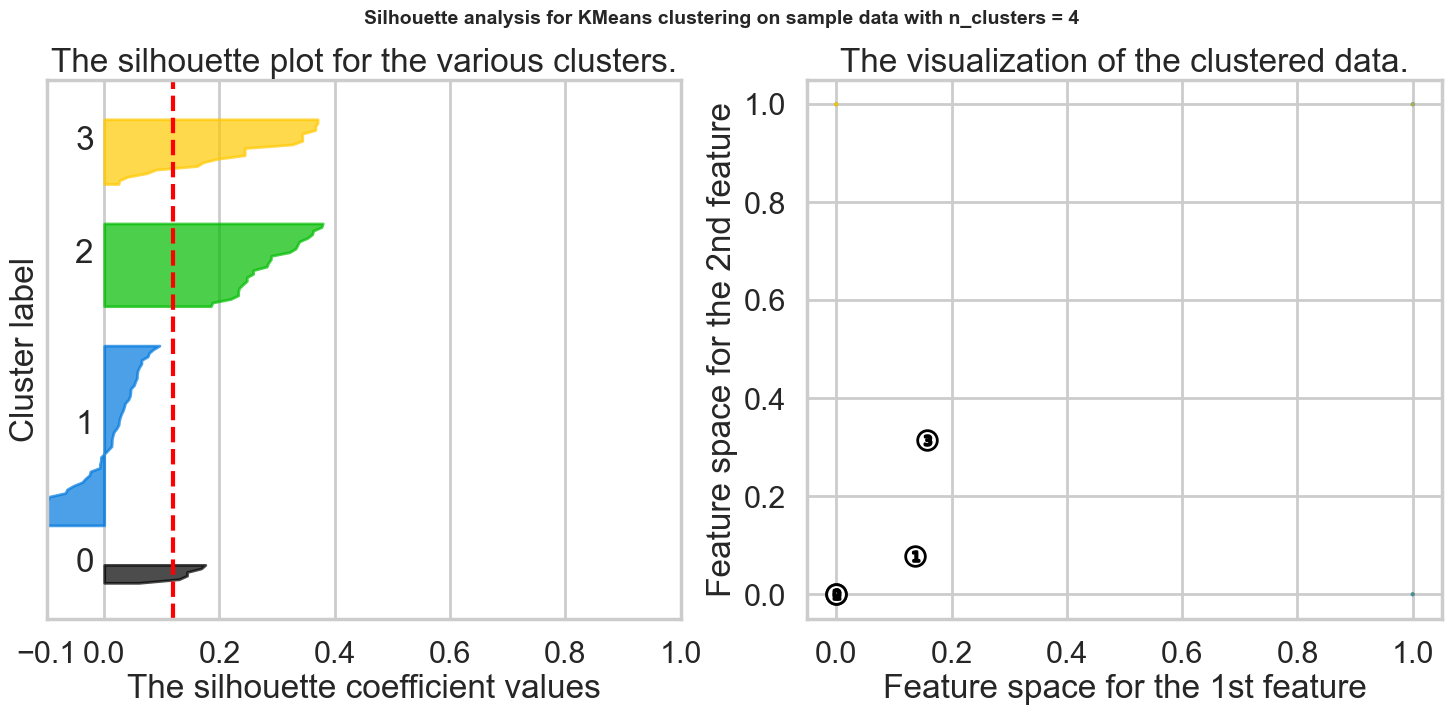

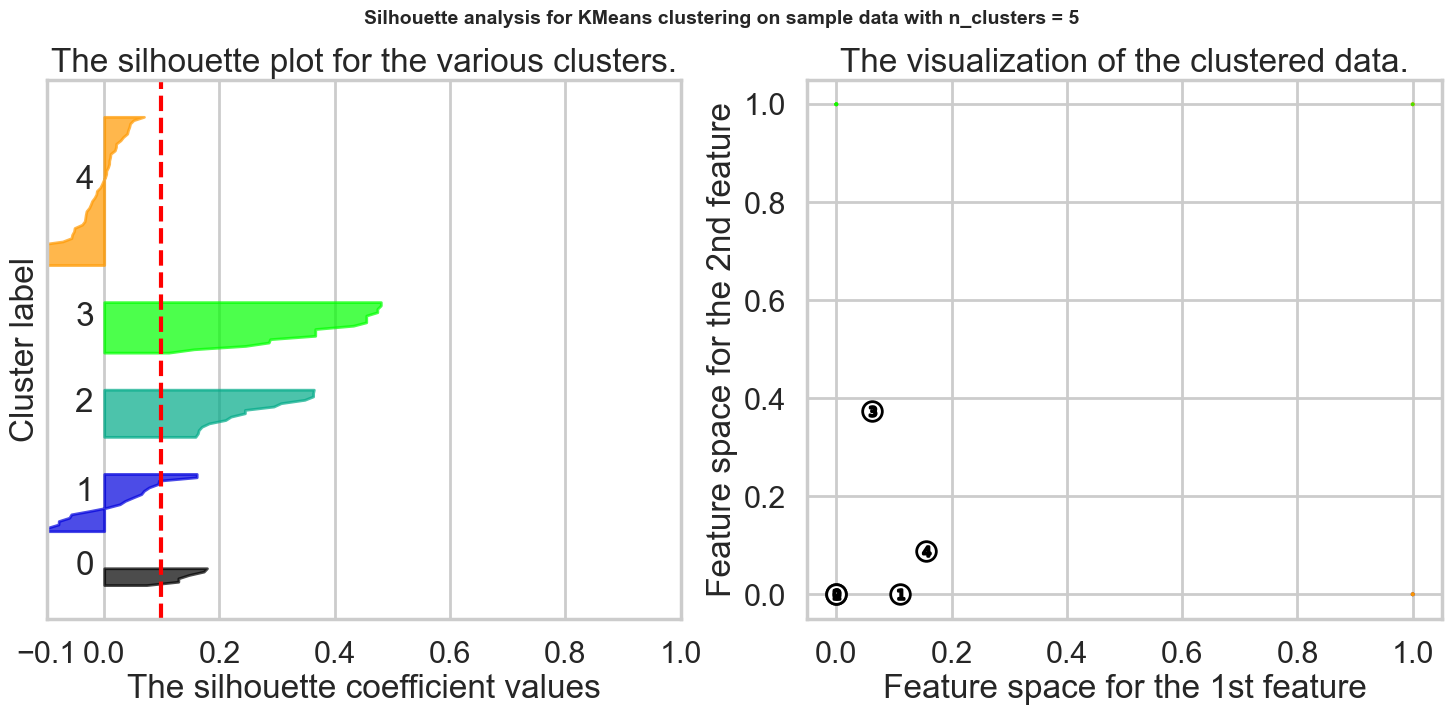

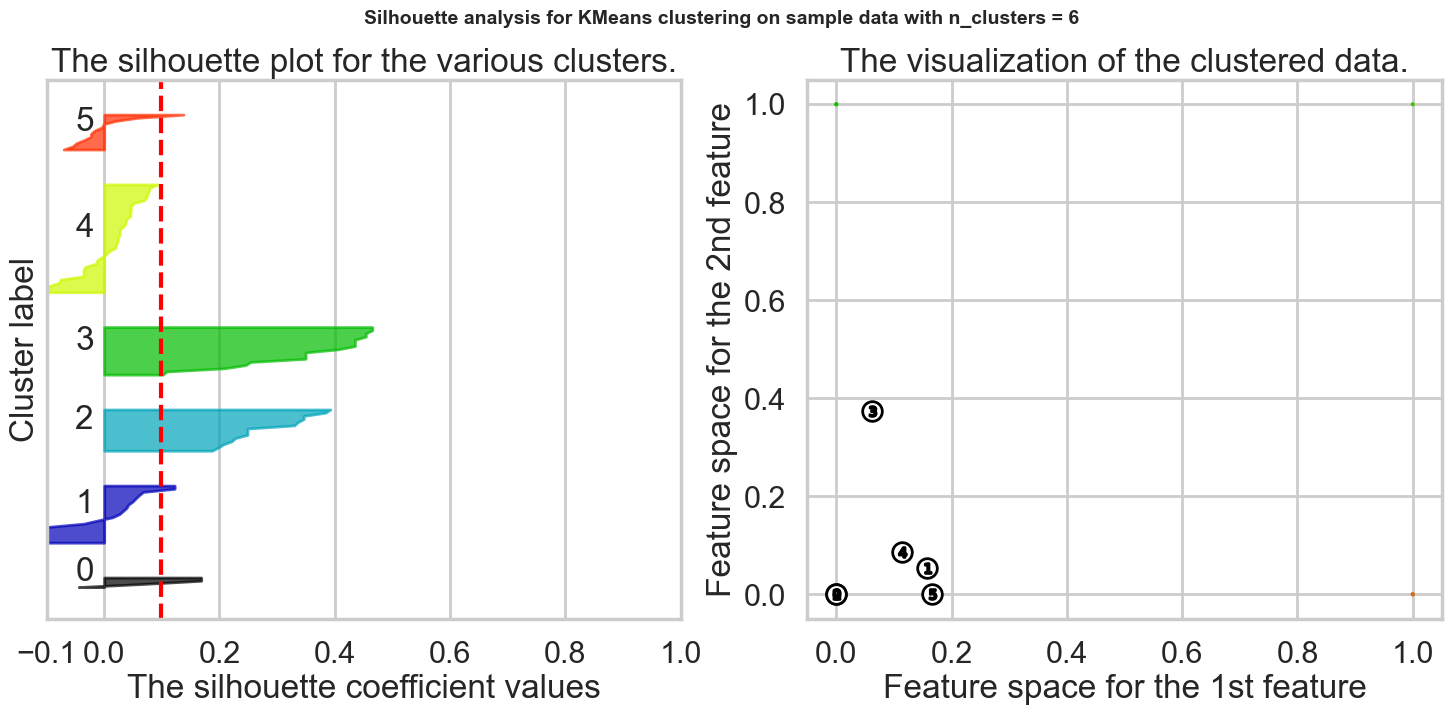

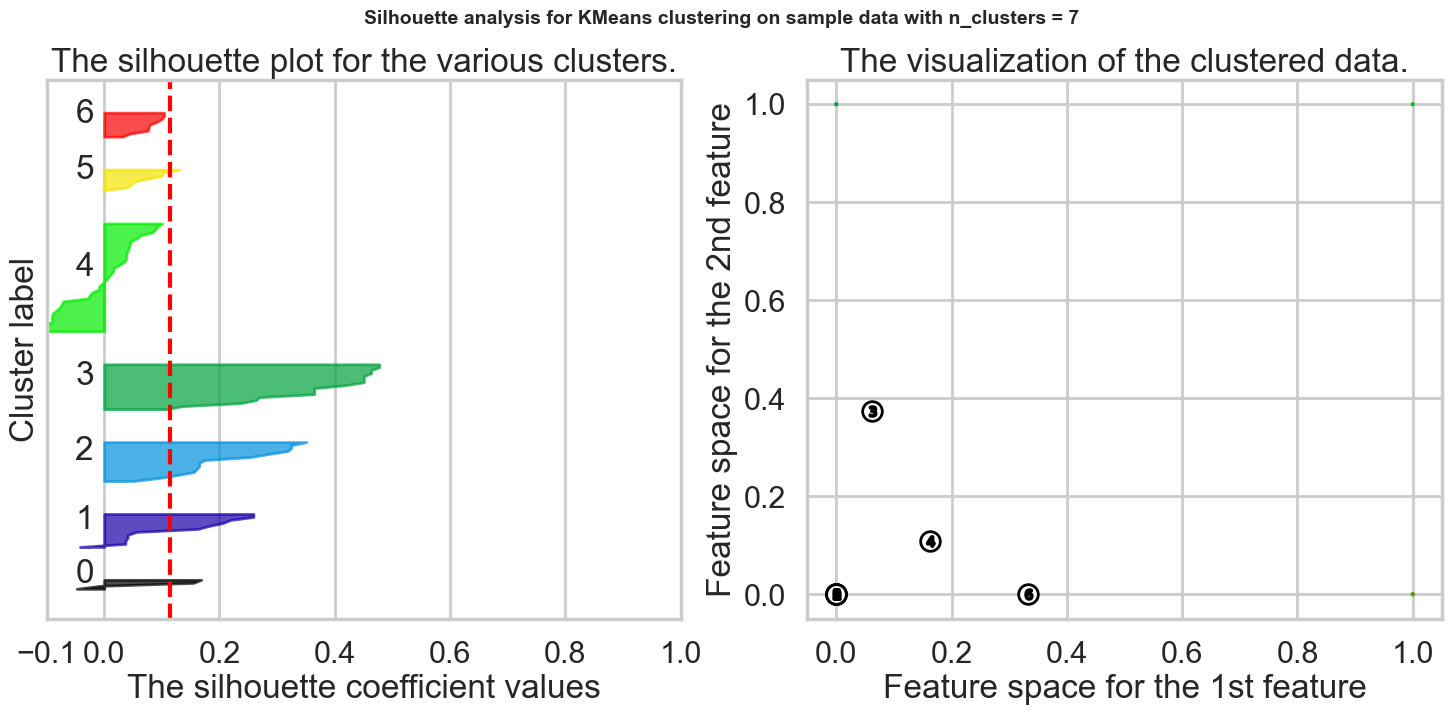

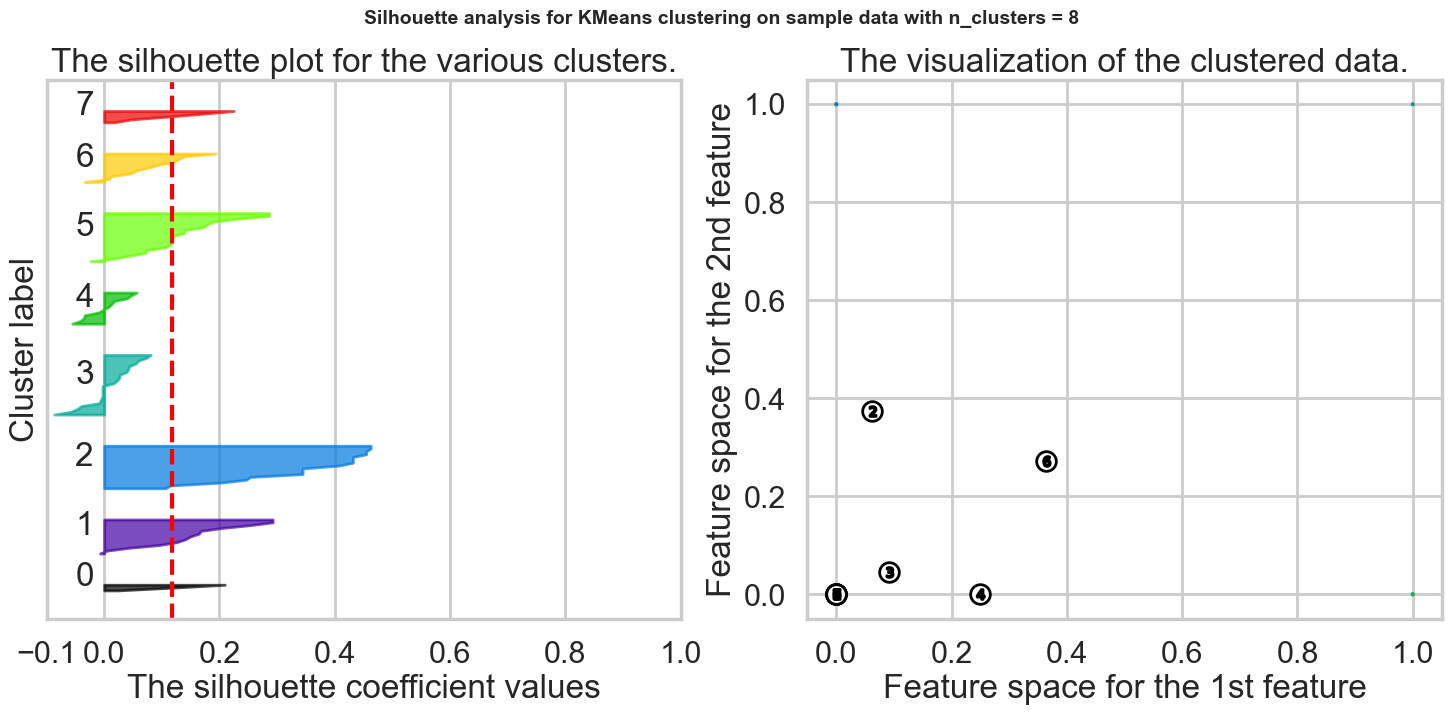

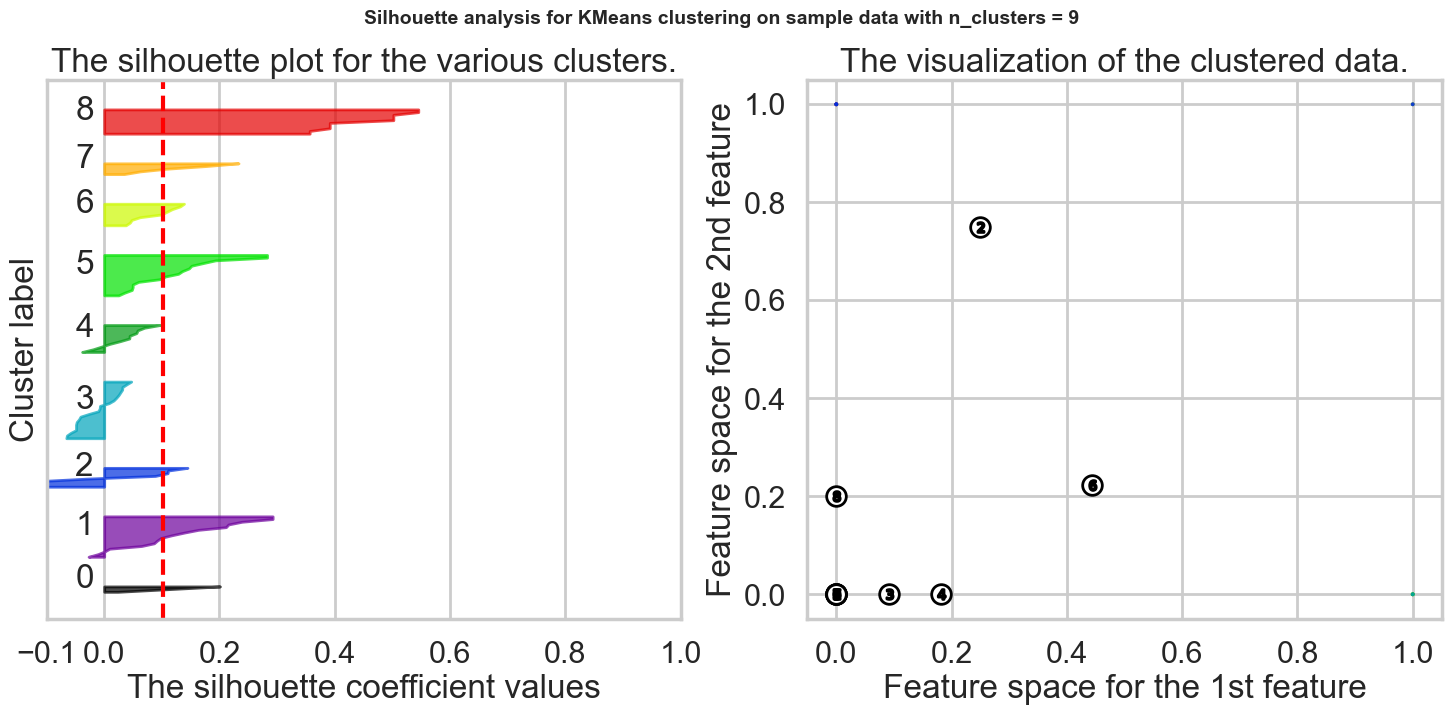

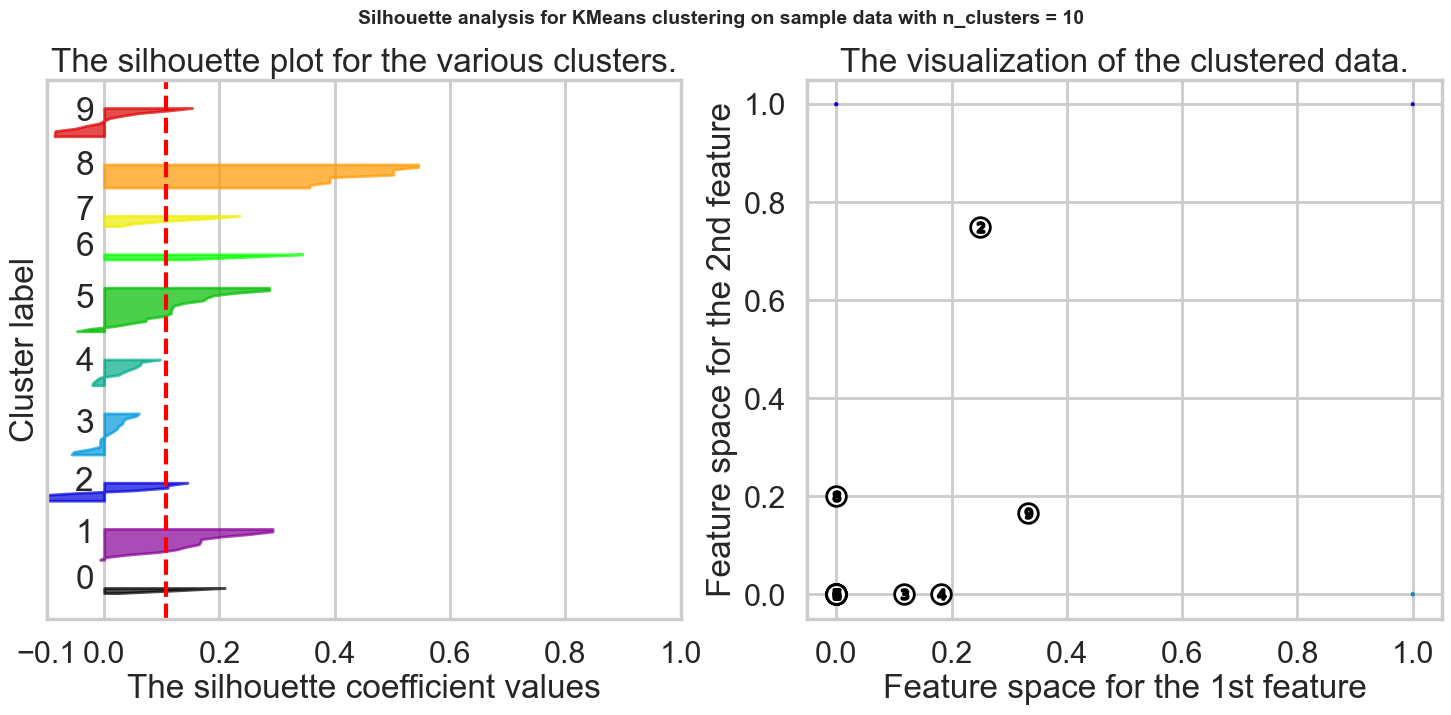

In [9]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init="auto")
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_cols[:, 0], x_cols[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
                 fontsize=14, fontweight='bold')

plt.show()

#### Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

It suggests K = 4 if we look at the maximum average =>  For n_clusters = 4 The average silhouette_score is : 0.11975644774033015

Using the Elbow method it suggested K = 3 (but could also be 6 or 8 perhaps...)

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

#### Reducing the dimensionality of my clustering data to 2 components using PCA

In [10]:
# Applying PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
x_cols_2d = pca.fit_transform(x_cols)

# Displaying the shape of the transformed data to confirm reduction to 2 components
x_cols_2d.shape, x_cols_2d[:5]  # Displaying the first 5 rows for a quick preview

((100, 2),
 array([[ 1.00757996,  0.10821467],
        [-0.28753924,  0.04471451],
        [-0.39203204,  1.03839141],
        [ 0.69947727, -0.02254222],
        [ 0.08818322, -0.47169543]]))

#### Dataframe

In [11]:
# Creating a DataFrame with customer name, cluster id, and the two PCA components
df_pca = pd.DataFrame({
    'customer_name': pivot_table.index,
    'cluster_id': model_best_k.labels_,
    'x': x_cols_2d[:, 0],
    'y': x_cols_2d[:, 1]
})

# Save the DataFrame to an Excel file for later use (see further in this notebook)
df_pca.to_excel('clustered_data.xlsx', index=False)

df_pca.head()

,customer_name,cluster_id,x,y
0,Adams,0,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695


#### Scatterplot

In [12]:
def select_distinct_colors(n, color_list):
    """
    Select n distinct colors from a predefined list of colors.
    Assumes that the provided list has visually distinct colors.
    """
    if n > len(color_list):
        raise ValueError("The number of requested colors exceeds the number of available distinct colors.")
    
    return random.sample(color_list, n)

# Predefined list of 12 visually distinct colors
predefined_colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
    '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#800000'
]

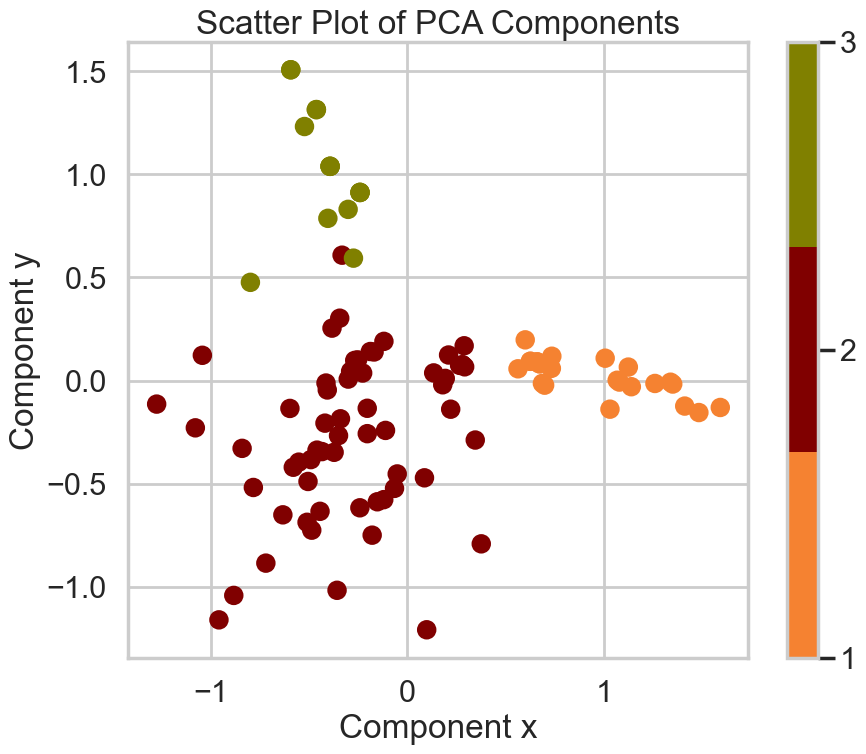

In [13]:
# Define a color map with 5 distinct colors
colors = select_distinct_colors(best_k, predefined_colors)

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca['x'], df_pca['y'], c=df_pca['cluster_id'], cmap=ListedColormap(colors))
plt.title('Scatter Plot of PCA Components')
plt.xlabel('Component x')
plt.ylabel('Component y')

# Calculate the tick positions for the colorbar
# The ticks are placed at the boundaries between color segments
ticks = [i for i in range(best_k)]

# Create colorbar with specified ticks
cbar = plt.colorbar(scatter, ticks=ticks)

# Set tick labels from 1 to 'best_k'
# The labels are aligned with the upper boundary of each color segment
cbar.set_ticklabels([str(i + 1) for i in range(best_k)])

plt.show()

#### How do the clusters look?

The colored clustering is pretty clear.  There is however not much distance between the clusters and there is a slight overlap between clusters 2 and 3.

#### Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?

The best value for K seems to be 3.  The Elbow method is pretty straightforward.

#### Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

The analysis of the wine data reveals interesting patterns across the three clusters (0 to 2) regarding varietal preferences, geographical origins, discount sensitivities, and responses to different campaigns.

**Cluster 1**: This cluster predominantly purchases wines with high discounts or specific varietals like Malbec or Pinot Noir, so it could indicate a group of customers that are price-sensitive or have a preference for certain wine types.

**Cluster 2**: This cluster may show an affinity for different varietals, such as Champagne or Espumante, or a preference for wines from a particular origin. They might also exhibit a trend in the minimum quantity they purchase, like preferring to buy in bulk, or show a tendency to buy wines that are not past peak.

**Cluster 3**: might be more inclined towards luxury or niche wines.

By examining the offers that each cluster predominantly responds to, we can craft targeted marketing strategies, tailor specific offers to each group, and potentially increase sales. 
For example, if cluster 1 prefers discounted wines, marketing campaigns for them might focus on promotions and discounts. Similarly, if cluster 2 shows a preference for certain varietals, future offers can be designed to cater to these tastes.

#### This following code creates a merged dataframe of the original data and the clustering data.  It is the base for the above analysis

In [14]:
file_path_wine = './WineKMC.xlsx'
df_offers = pd.read_excel(file_path_wine, sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_transactions = pd.read_excel(file_path_wine, sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]

# Merging the clustered data with the transactions data
df_transactions_clustered = pd.merge(df_transactions, df_pca, left_on='customer_name', right_on='customer_name')

# Merging the above with the offers data
df_full_data = pd.merge(df_transactions_clustered, df_offers, left_on='offer_id', right_on='offer_id')

df_full_data

,customer_name,offer_id,cluster_id,x,y,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,2,-0.300227,0.829765,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,2,-0.403273,0.786296,January,Pinot Noir,72,17,France,False
2,Martin,2,1,-0.382241,0.254034,January,Pinot Noir,72,17,France,False
3,Jackson,2,1,-0.839578,-0.328823,January,Pinot Noir,72,17,France,False
4,Campbell,2,2,-0.522247,1.231406,January,Pinot Noir,72,17,France,False
...,...,...,...,...,...,...,...,...,...,...,...
319,Hill,13,0,1.140585,-0.029993,May,Merlot,6,43,Chile,False
320,Carter,13,0,1.260763,-0.014255,May,Merlot,6,43,Chile,False
321,James,13,0,1.484258,-0.155233,May,Merlot,6,43,Chile,False
322,Hughes,13,0,1.593182,-0.130641,May,Merlot,6,43,Chile,False


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

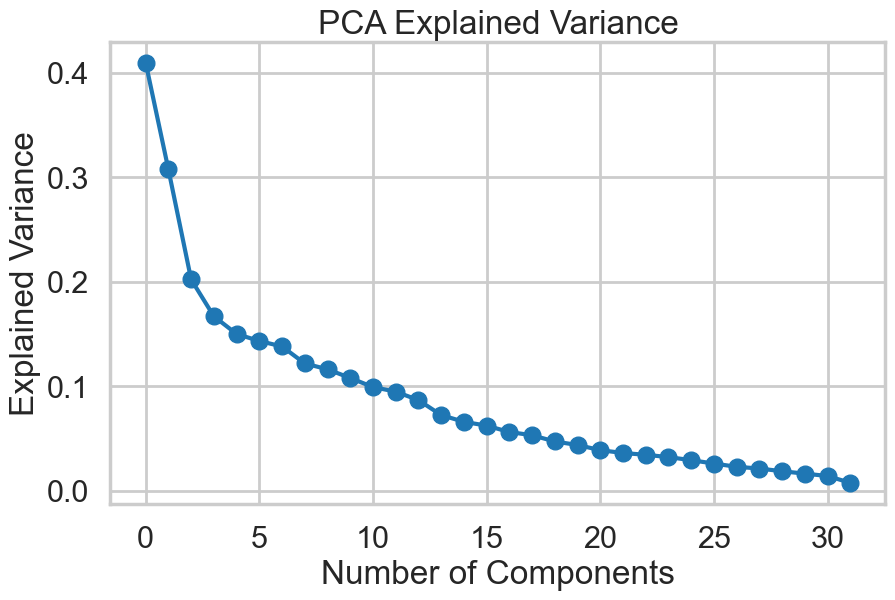

array([0.4096489 , 0.30753551, 0.2022926 , 0.16703717, 0.15015248,
       0.1434373 , 0.13818887, 0.12192294, 0.11636172, 0.10804271,
       0.09937813, 0.09495961, 0.08690352, 0.07256738, 0.0660996 ,
       0.06245473, 0.05634388, 0.05327395, 0.04728801, 0.04393911,
       0.03900424, 0.03625783, 0.03455714, 0.03235091, 0.02940632,
       0.02618221, 0.02308167, 0.02142632, 0.018814  , 0.0165252 ,
       0.01426187, 0.0077789 ])

In [15]:
# Initialize a new PCA model with a default number of components.
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Plotting the explained variance to find the elbow point
plt.figure(figsize=(10, 6))
plt.plot(pca.explained_variance_, marker='o')
plt.title('PCA Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

# Returning the explained variance values for further analysis
pca.explained_variance_

From the plot, it seems that the elbow point occurs around the 3rd or 4th component. This suggests that the first three or four principal components capture most of the significant variance in the data, and adding more components beyond this point does not contribute as much additional information.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [16]:
# Defining the clustering methods with their respective names
clustering_methods = {
    "Affinity Propagation": AffinityPropagation(),
    "Spectral Clustering": SpectralClustering(),
    "Agglomerative Clustering": AgglomerativeClustering(),
    "DBSCAN": DBSCAN()
}

# Looping through each method to apply clustering
cluster_summaries = {}
for method_name, method in clustering_methods.items():
    # Applying clustering
    clusters = method.fit_predict(x_cols)

    # Counting the number of points in each cluster
    cluster_labels, counts = np.unique(clusters, return_counts=True)

    # Storing the results
    cluster_summaries[method_name] = dict(zip(cluster_labels, counts))

cluster_summaries

{'Affinity Propagation': {0: 7,
  1: 3,
  2: 6,
  3: 10,
  4: 7,
  5: 3,
  6: 10,
  7: 4,
  8: 3,
  9: 12,
  10: 5,
  11: 11,
  12: 8,
  13: 11},
 'Spectral Clustering': {0: 4, 1: 15, 2: 11, 3: 7, 4: 14, 5: 17, 6: 29, 7: 3},
 'Agglomerative Clustering': {0: 66, 1: 34},
 'DBSCAN': {-1: 100}}

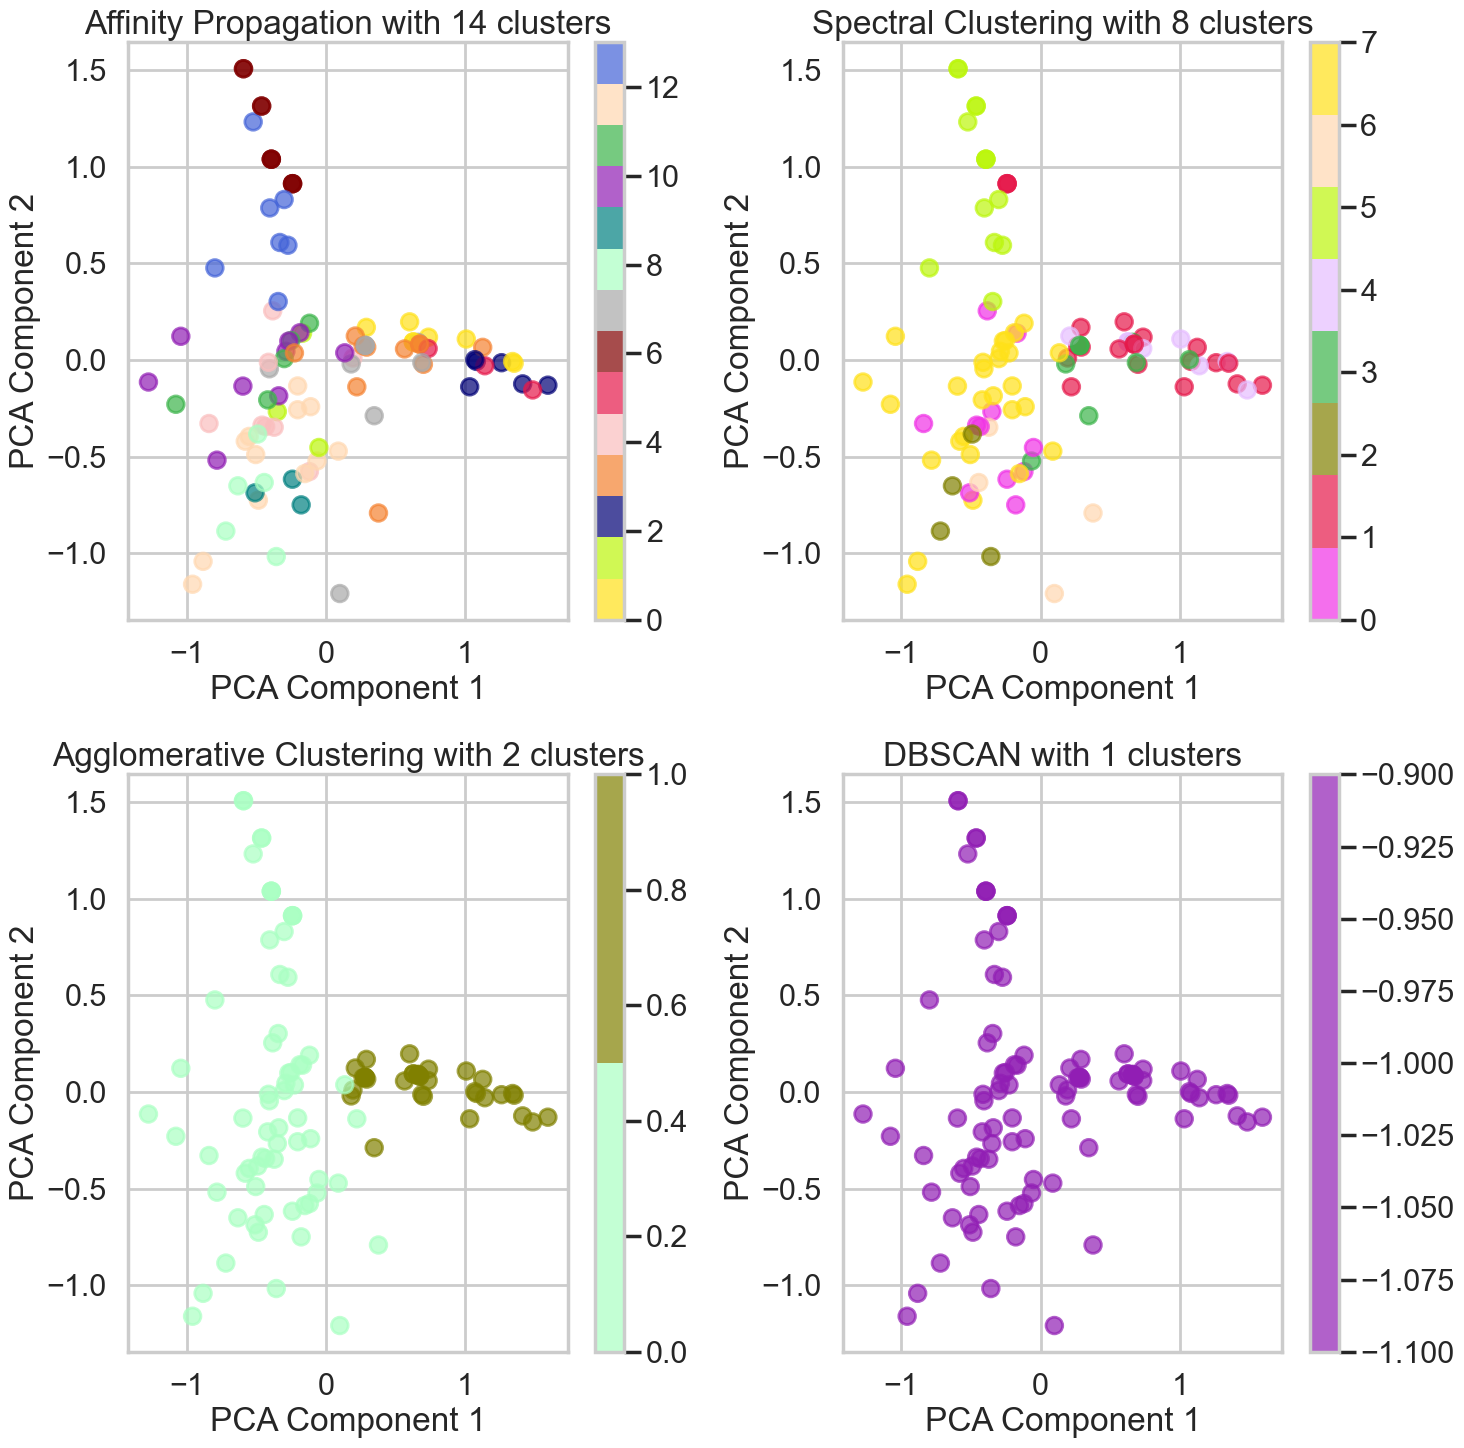

In [17]:
# Applying PCA for dimensionality reduction to 2 components for visualization
pca_2d = PCA(n_components=2)
x_cols_2d = pca_2d.fit_transform(x_cols)

# Generating scatter plots for each clustering method
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Titles for subplots
titles = ["Affinity Propagation", "Spectral Clustering", "Agglomerative Clustering", "DBSCAN"]
i=0
# Looping through each method and plotting
for ax, title in zip(axs.flatten(), titles):
    cluster_count = [len(values) for values in cluster_summaries.values()][i]
    colors = select_distinct_colors(cluster_count, predefined_colors)
    clusters = clustering_methods[title].fit_predict(x_cols)
    scatter = ax.scatter(x_cols_2d[:, 0], x_cols_2d[:, 1], c=clusters, cmap=ListedColormap(colors), alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_title(f"{title} with {[len(values) for values in cluster_summaries.values()][i]} clusters")
    i=i+1
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

- The Affinity Propagation method created 14 clusters.  It distributed the data points among a relatively large number of smaller clusters.  This method might be useful when the number of clusters is not known a priori.  I could be better for datasets where many natural groupings exist.

- The Spectral Clustering method formed 8 clusters.  This method is known for its ability to identify non-linearly separable clusters.  It has more  clusters than Agglomerative Clustering, possibly capturing more nuances in the data.

- The Agglomerative Clustering method generated 2 clusters and is a hierarchical clustering method.  It might oversimplify the data by grouping them into just two categories.

- the DBSCAN method classified all points as outliers (-1) with default parameters.  This method is known to be highly sensitive to parameter settings.  Without proper tuning, this might not be effective for this dataset.

Affinity Propagation might reveal niche groups with specific tastes, beneficial for targeted marketing.
Spectral Clustering could uncover complex patterns in customer preferences, perhaps aligning with regional or seasonal trends.
Agglomerative Clustering might group customers into broad categories, like regular and occasional buyers, useful for general marketing strategies.
DBSCAN, with proper parameter tuning, could identify core groups of loyal customers and outliers who are infrequent but high-value buyers.